# COGS 118B Final Project (Group RILS): All Code #

# 1) Data Cleaning #

In [1]:
import pandas as pd
import numpy as np

## Load Data ##

In [3]:
df = pd.read_csv('movies.csv')
df.head()
df.shape[0]

722480

## Drop Irrelevant Columns ##

In [4]:
#not sure what else we want to drop 
columns_to_remove = ['overview', 'keywords', 'poster_path', 'backdrop_path']
df = df.drop(columns = columns_to_remove)
df.head()

,id,title,genres,original_language,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,recommendations
0,615656,Meg 2: The Trench,Action-Science Fiction-Horror,en,8763.998,Apelles Entertainment-Warner Bros. Pictures-di...,2023-08-02,129000000.0,352056482.0,116.0,Released,Back for seconds.,7.079,1365.0,Jason Statham-Wu Jing-Shuya Sophia Cai-Sergio ...,1006462-298618-569094-1061181-346698-1076487-6...
1,758323,The Pope's Exorcist,Horror-Mystery-Thriller,en,5953.227,Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...,2023-04-05,18000000.0,65675816.0,103.0,Released,Inspired by the actual files of Father Gabriel...,7.433,545.0,Russell Crowe-Daniel Zovatto-Alex Essoe-Franco...,713704-296271-502356-1076605-1084225-1008005-9...
2,667538,Transformers: Rise of the Beasts,Action-Adventure-Science Fiction,en,5409.104,Skydance-Paramount-di Bonaventura Pictures-Bay...,2023-06-06,200000000.0,407045464.0,127.0,Released,Unite or fall.,7.340,1007.0,Anthony Ramos-Dominique Fishback-Luna Lauren V...,496450-569094-298618-385687-877100-598331-4628...
3,640146,Ant-Man and the Wasp: Quantumania,Action-Adventure-Science Fiction,en,4425.387,Marvel Studios-Kevin Feige Productions,2023-02-15,200000000.0,475766228.0,125.0,Released,Witness the beginning of a new dynasty.,6.507,2811.0,Paul Rudd-Evangeline Lilly-Jonathan Majors-Kat...,823999-676841-868759-734048-267805-965839-1033...
4,677179,Creed III,Drama-Action,en,3994.342,Metro-Goldwyn-Mayer-Proximity Media-Balboa Pro...,2023-03-01,75000000.0,269000000.0,116.0,Released,You can't run from your past.,7.262,1129.0,Michael B. Jordan-Tessa Thompson-Jonathan Majo...,965839-267805-943822-842942-1035806-823999-107...


## Drop Duplicates ##

In [5]:
df_no_duplicates = df.drop_duplicates()
df_no_duplicates.shape[0]

722462

## Drop Na Values ##

In [6]:
df_cleaned = df_no_duplicates.dropna(subset=['recommendations'])
df_cleaned.head()
df_cleaned.shape[0]

#this might be an issue but i figured data without recommendations wouldnt be needed?
#when i drop all Na values, the number drops to 14,000ish, might need new dataset

34894

## One Hot Encoding for Production Companies, Credits, and Genre ##

In [7]:
from collections import Counter

In [8]:
df_copy = df.copy()

# Handling missing values by replacing NaNs with an empty string
df_copy['production_companies'] = df_copy['production_companies'].fillna('')
df_copy['credits'] = df_copy['credits'].fillna('')

# Splitting the production companies by '-' and flattening the list
all_companies = [company for sublist in df_copy['production_companies'].apply(lambda x: str(x).split('-')) for company in sublist]

# Filter companies occurring at least 1750 times and are not empty
company_counts = Counter(all_companies)
unique_companies = [company for company, count in company_counts.items() if count >= 1750 and company != '']

print("Unique Companies:", unique_companies)
print("Number of Unique Companies:", len(unique_companies))

# Company One Hot Encoding
company_data = {}
for company in unique_companies:
    company_data[company] = df_copy['production_companies'].apply(lambda x: 1 if company in x else 0)

# Splitting the credits by '-' and flattening the list
all_credits = [credit for sublist in df_copy['credits'].apply(lambda x: str(x).split('-')) for credit in sublist]

# Filter credits occurring at least 400 and are full names (at least 2 names)
credit_counts = Counter(all_credits)
unique_credits = [credit for credit, count in credit_counts.items() if count >= 400 and len(credit.split()) >= 2]

print("Unique Credits:", unique_credits)
print("Number of Unique Credits:", len(unique_credits))

# Credits One Hot Encoding
credit_data = {}
for credit in unique_credits:
    credit_data[credit] = df_copy['credits'].apply(lambda x: 1 if credit in x else 0)

credit_df = pd.DataFrame(credit_data)
df_copy = pd.concat([df_copy, credit_df], axis=1)
company_df = pd.DataFrame(company_data)
df_copy = pd.concat([df_copy, company_df], axis=1)

Unique Companies: ['Warner Bros. Pictures', 'Paramount', 'Metro', 'Goldwyn', 'Mayer', 'Universal Pictures', 'Columbia Pictures', 'Toei Company', 'ARTE', 'ZDF', 'Film', 'ONF | NFB', 'BBC']
Number of Unique Companies: 13
Unique Credits: ['Frank Welker', 'Eric Roberts', 'Mark Calaway', 'Mel Blanc', 'Paul Michael Lévesque', 'Bess Flowers', 'Allen Jones', 'Nedumudi Venu', 'KPAC Lalitha', 'Jagathy Sreekumar']
Number of Unique Credits: 10


In [9]:
# Split the 'recommendations' column by '-' and expand the result into separate columns
recommendations_split = df_copy['recommendations'].str.split('-', expand=True)

# Truncate recommendations_split to include only the first five split columns
recommendations_split = recommendations_split.iloc[:, :5]

# Assign new column names to the truncated columns
recommendations_split.columns = ['recommendation_1', 'recommendation_2', 'recommendation_3', 'recommendation_4', 'recommendation_5']

# One Hot Encoding for genres
genres_split = df_copy['genres'].str.get_dummies(sep='-')

# Adding everything together and removing all the old columns
df_copy = pd.concat([df_copy, genres_split, recommendations_split], axis=1)
df_copy = df_copy.drop(columns=['genres', 'recommendations', 'production_companies', 'credits'])

print(df_copy.columns)

Index(['id', 'title', 'original_language', 'popularity', 'release_date',
       'budget', 'revenue', 'runtime', 'status', 'tagline', 'vote_average',
       'vote_count', 'Frank Welker', 'Eric Roberts', 'Mark Calaway',
       'Mel Blanc', 'Paul Michael Lévesque', 'Bess Flowers', 'Allen Jones',
       'Nedumudi Venu', 'KPAC Lalitha', 'Jagathy Sreekumar',
       'Warner Bros. Pictures', 'Paramount', 'Metro', 'Goldwyn', 'Mayer',
       'Universal Pictures', 'Columbia Pictures', 'Toei Company', 'ARTE',
       'ZDF', 'Film', 'ONF | NFB', 'BBC', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western', 'recommendation_1',
       'recommendation_2', 'recommendation_3', 'recommendation_4',
       'recommendation_5'],
      dtype='object')


In [10]:
df_copy['is_english'] = 0
df_copy.loc[df_copy['original_language'] == 'en', 'is_english'] = 1

df_copy.drop('original_language', axis=1, inplace=True)

df_copy['release_date'] = pd.to_datetime(df_copy['release_date'])
df_copy['release_year'] = df_copy['release_date'].dt.year

df_copy.drop('release_date', axis=1, inplace=True)

print(df_copy.columns)

Index(['id', 'title', 'popularity', 'budget', 'revenue', 'runtime', 'status',
       'tagline', 'vote_average', 'vote_count', 'Frank Welker', 'Eric Roberts',
       'Mark Calaway', 'Mel Blanc', 'Paul Michael Lévesque', 'Bess Flowers',
       'Allen Jones', 'Nedumudi Venu', 'KPAC Lalitha', 'Jagathy Sreekumar',
       'Warner Bros. Pictures', 'Paramount', 'Metro', 'Goldwyn', 'Mayer',
       'Universal Pictures', 'Columbia Pictures', 'Toei Company', 'ARTE',
       'ZDF', 'Film', 'ONF | NFB', 'BBC', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western', 'recommendation_1',
       'recommendation_2', 'recommendation_3', 'recommendation_4',
       'recommendation_5', 'is_english', 'release_year'],
      dtype='object')


In [11]:
print(df_copy['release_year'])

0         2023.0
1         2023.0
2         2023.0
3         2023.0
4         2023.0
           ...  
722475    2013.0
722476    2016.0
722477    1973.0
722478    1970.0
722479       NaN
Name: release_year, Length: 722480, dtype: float64


## Making New Dfs for Clustering & Regression ##

In [12]:
# Removing columns for clustering 
df_clustering = df_copy.drop(columns=['popularity', 'budget', 'status', 'tagline', 'vote_average', 'vote_count'])

#Artificially inflate 'genre' by setting all one-hot encoded values to 2
df_clustering['Action'] = df_clustering['Action'].replace(1,2)
df_clustering['Adventure'] = df_clustering['Adventure'].replace(1,2)
df_clustering['Animation'] = df_clustering['Animation'].replace(1,2)
df_clustering['Comedy'] = df_clustering['Comedy'].replace(1,2)
df_clustering['Crime'] = df_clustering['Crime'].replace(1,2)
df_clustering['Documentary'] = df_clustering['Documentary'].replace(1,2)
df_clustering['Drama'] = df_clustering['Drama'].replace(1,2)
df_clustering['Family'] = df_clustering['Family'].replace(1,2)
df_clustering['Fantasy'] = df_clustering['Fantasy'].replace(1,2)
df_clustering['History'] = df_clustering['History'].replace(1,2)
df_clustering['Horror'] = df_clustering['Horror'].replace(1,2)
df_clustering['Music'] = df_clustering['Music'].replace(1,2)
df_clustering['Mystery'] = df_clustering['Mystery'].replace(1,2)
df_clustering['Romance'] = df_clustering['Romance'].replace(1,2)
df_clustering['Science Fiction'] = df_clustering['Science Fiction'].replace(1,2)
df_clustering['TV Movie'] = df_clustering['TV Movie'].replace(1,2)
df_clustering['War'] = df_clustering['War'].replace(1,2)
df_clustering['Western'] = df_clustering['Western'].replace(1,2)

print(df_clustering.columns)
print("Number of Total Variables:", len(df_clustering.columns))
print("Number of Unique Credits:", len(unique_credits))
print("Number of Unique Companies:", len(unique_companies))
print("Number of Unique Genres:", len(genres_split.columns))
print("Number of Other Variables:", len(df_clustering.columns) - len(unique_credits) - len(unique_companies) - len(genres_split.columns) - 7)
df_clustering.head()

Index(['id', 'title', 'revenue', 'runtime', 'Frank Welker', 'Eric Roberts',
       'Mark Calaway', 'Mel Blanc', 'Paul Michael Lévesque', 'Bess Flowers',
       'Allen Jones', 'Nedumudi Venu', 'KPAC Lalitha', 'Jagathy Sreekumar',
       'Warner Bros. Pictures', 'Paramount', 'Metro', 'Goldwyn', 'Mayer',
       'Universal Pictures', 'Columbia Pictures', 'Toei Company', 'ARTE',
       'ZDF', 'Film', 'ONF | NFB', 'BBC', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western', 'recommendation_1',
       'recommendation_2', 'recommendation_3', 'recommendation_4',
       'recommendation_5', 'is_english', 'release_year'],
      dtype='object')
Number of Total Variables: 53
Number of Unique Credits: 10
Number of Unique Companies: 13
Number of Unique Genres: 19
Number of Other Variables: 4


,id,title,revenue,runtime,Frank Welker,Eric Roberts,Mark Calaway,Mel Blanc,Paul Michael Lévesque,Bess Flowers,...,Thriller,War,Western,recommendation_1,recommendation_2,recommendation_3,recommendation_4,recommendation_5,is_english,release_year
0,615656,Meg 2: The Trench,352056482.0,116.0,0,0,0,0,0,0,...,0,0,0,1006462,298618,569094,1061181,346698,1,2023.0
1,758323,The Pope's Exorcist,65675816.0,103.0,0,0,0,0,0,0,...,1,0,0,713704,296271,502356,1076605,1084225,1,2023.0
2,667538,Transformers: Rise of the Beasts,407045464.0,127.0,0,0,0,0,0,0,...,0,0,0,496450,569094,298618,385687,877100,1,2023.0
3,640146,Ant-Man and the Wasp: Quantumania,475766228.0,125.0,0,0,0,0,0,0,...,0,0,0,823999,676841,868759,734048,267805,1,2023.0
4,677179,Creed III,269000000.0,116.0,0,0,0,0,0,0,...,0,0,0,965839,267805,943822,842942,1035806,1,2023.0


In [13]:
# Columns for regression, will still need to calculate euclidean distance for each cluster
df_regression = df_copy[['id', 'title', 'release_year', 'is_english', 'revenue', 'vote_average', 'vote_count', 'recommendation_1', 'recommendation_2', 'recommendation_3', 'recommendation_4', 'recommendation_5']]
df_regression.head()

,id,title,release_year,is_english,revenue,vote_average,vote_count,recommendation_1,recommendation_2,recommendation_3,recommendation_4,recommendation_5
0,615656,Meg 2: The Trench,2023.0,1,352056482.0,7.079,1365.0,1006462,298618,569094,1061181,346698
1,758323,The Pope's Exorcist,2023.0,1,65675816.0,7.433,545.0,713704,296271,502356,1076605,1084225
2,667538,Transformers: Rise of the Beasts,2023.0,1,407045464.0,7.340,1007.0,496450,569094,298618,385687,877100
3,640146,Ant-Man and the Wasp: Quantumania,2023.0,1,475766228.0,6.507,2811.0,823999,676841,868759,734048,267805
4,677179,Creed III,2023.0,1,269000000.0,7.262,1129.0,965839,267805,943822,842942,1035806


# 2) Clustering Code #

In [16]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

## Step 1: PCA

In [18]:
df_clustering.dropna(inplace=True)

features = df_clustering[['revenue', 'release_year', 'is_english',
       'runtime', 'Frank Welker', 'Eric Roberts', 'Mark Calaway', 'Mel Blanc',
       'Paul Michael Lévesque', 'Bess Flowers', 'Allen Jones', 'Nedumudi Venu',
       'KPAC Lalitha', 'Jagathy Sreekumar', 'Warner Bros. Pictures',
       'Paramount', 'Metro', 'Goldwyn', 'Mayer', 'Universal Pictures',
       'Columbia Pictures', 'Toei Company', 'ARTE', 'ZDF', 'Film', 'ONF | NFB',
       'BBC', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western']]

features_to_scale = ['revenue', 'release_year', 'is_english', 'runtime', 'Frank Welker', 'Eric Roberts', 
                     'Mark Calaway', 'Mel Blanc', 'Paul Michael Lévesque', 'Bess Flowers', 
                     'Allen Jones', 'Nedumudi Venu', 'KPAC Lalitha', 'Jagathy Sreekumar', 
                     'Warner Bros. Pictures', 'Paramount', 'Metro', 'Goldwyn', 'Mayer', 
                     'Universal Pictures', 'Columbia Pictures', 'Toei Company', 'ARTE', 
                     'ZDF', 'Film', 'ONF | NFB', 'BBC']

# Select features for PCA
features_for_pca = [col for col in features.columns if col not in features_to_scale]

# Scale the features that need to be scaled
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_clustering[features_to_scale])

# Perform PCA
pca = PCA()
pca.fit(np.concatenate((scaled_features, df_clustering[features_for_pca]), axis=1))

# Determine number of principal components to explain 80% of the variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.8) + 1

print("Number of components explaining 80% variance:", n_components)

pca_final = PCA(n_components=n_components)
pca_final_features = pca_final.fit_transform(np.concatenate((scaled_features, df_clustering[features_for_pca]), axis=1))

Number of components explaining 80% variance: 23


## Step 2: K-Means Clustering

C:\Users\rebec\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rebec\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rebec\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rebec\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

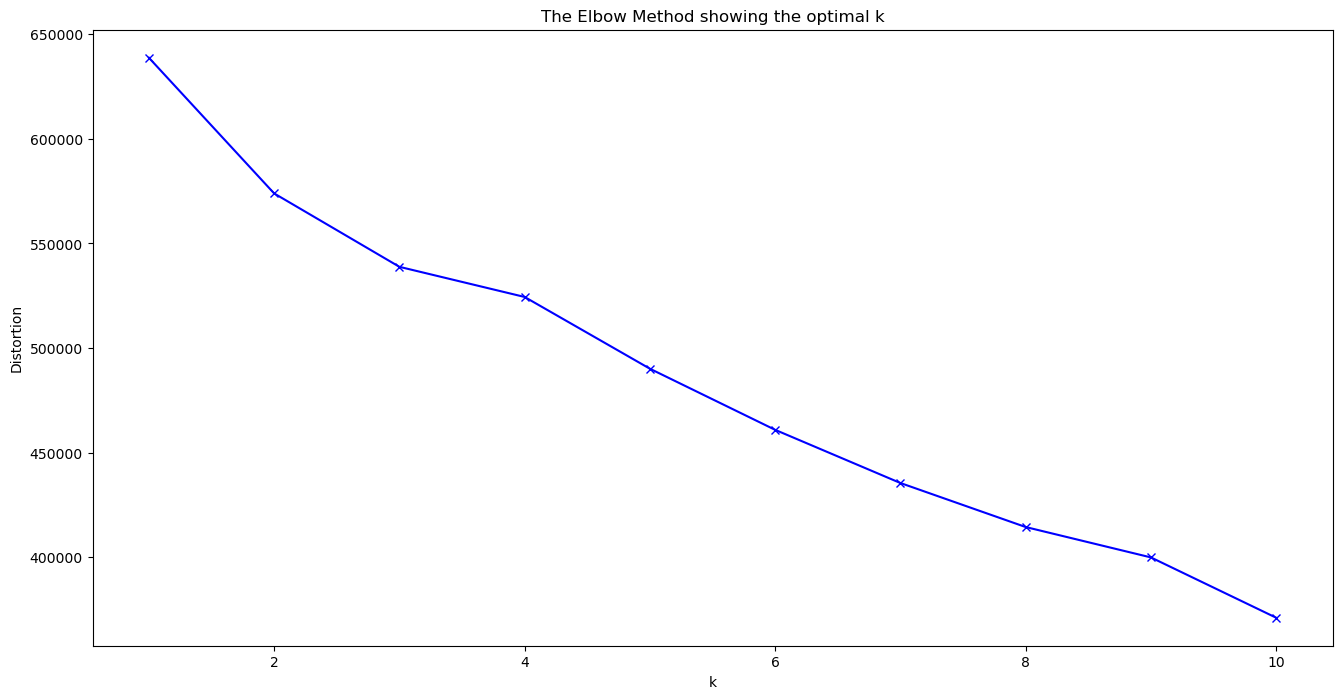

In [19]:
distortions = []
K = range(1, 11)  # Assuming we test for k values from 1 to 10
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(pca_final_features)
    distortions.append(kmeanModel.inertia_)

#Plot the elbow curve
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [20]:
# From graph above:
optimal_k = 3

# Perform K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans.fit(pca_final_features)
clusters = kmeans.labels_

# Assign clusters to original dataframe
df_clustering['cluster'] = clusters

C:\Users\rebec\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


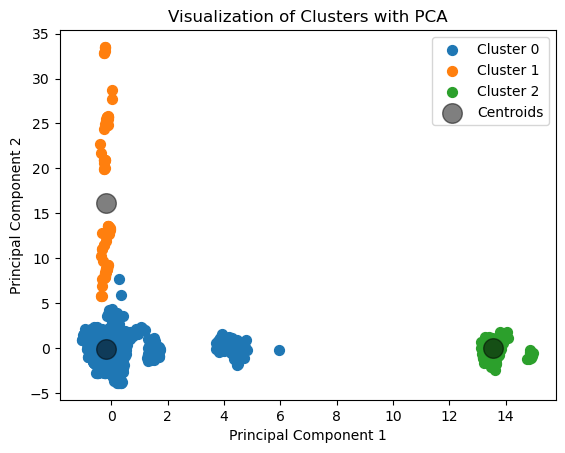

In [33]:
import matplotlib.pyplot as plt

# Plot each cluster
for i in range(optimal_k):
    # Select only data observations with cluster label == i
    ds = pca_final_features[clusters == i]
    # Plot the data observations
    plt.scatter(ds[:, 0], ds[:, 1], s=50, label=f'Cluster {i}')

# Plot the centroids of the clusters
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5, label='Centroids')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Visualization of Clusters with PCA')
plt.legend() 
plt.show()

In [34]:
columns = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western', 'Additional Feature 1', 'Additional Feature 2', 'Additional Feature 3',
    'Additional Feature 4']
centroids_df = pd.DataFrame(centers, columns=columns)

def label_clusters(centroids):
    labels = []
    for index, row in centroids.iterrows():
        label = []
        threshold = 0.5
        if row['Action'] > threshold:
            label.append('Action')
        if row['Adventure'] > threshold:
            label.append('Adventure')
        if row['Animation'] > threshold:
            label.append('Animation')
        if row['Comedy'] > threshold:
            label.append('Comedy')
        if row['Crime'] > threshold:
            label.append('Crime')
        if row['Documentary'] > threshold:
            label.append('Documentary')
        if row['Drama'] > threshold:
            label.append('Drama')
        if row['Family'] > threshold:
            label.append('Family')
        if row['Fantasy'] > threshold:
            label.append('Fantasy')
        if row['History'] > threshold:
            label.append('History')
        if row['Horror'] > threshold:
            label.append('Horror')
        if row['Music'] > threshold:
            label.append('Music')
        if row['Mystery'] > threshold:
            label.append('Mystery')
        if row['Romance'] > threshold:
            label.append('Romance')
        if row['Science Fiction'] > threshold:
            label.append('Science Fiction')
        if row['TV Movie'] > threshold:
            label.append('TV Movie')   
        if row['Thriller'] > threshold:
            label.append('Thriller')  
        if row['War'] > threshold:
            label.append('War')
        if row['Western'] > threshold:
            label.append('Western')
        # Construct the label based on the significant features
        # If no features were above the threshold, label it as 'Mixed' or similar
        if not label: 
            label.append('Mixed')
        labels.append('-'.join(label))
    return labels

# Assign labels to clusters
cluster_labels = label_clusters(centroids_df)
cluster_label_dict = {i: label for i, label in enumerate(cluster_labels)}
cluster_label_dict

{0: 'Mixed', 1: 'Adventure-Animation-Comedy-Western', 2: 'Action-Comedy'}

## Step 4: Silhouette Score Evaluation

- We will calculate the **Silhouette Score** to see how well the clusters are separated.
- A higher score indicates a better-defined cluster

In [35]:
silhouette_avg = silhouette_score(scaled_features, clusters)
print(f"The silhouette score for k={optimal_k}: {silhouette_avg:.2f}")

The silhouette score for k=3: 0.70


## Step 5: Recommendation System

In [56]:
import numpy as np
from scipy.spatial.distance import cdist

user_input_genres = ['Documentary']

genre_columns = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western', 'Additional Feature 1', 'Additional Feature 2', 'Additional Feature 3',
    'Additional Feature 4']

# Convert user input to the same format as your model's features (one-hot encoding)
user_input_encoded = [1 if genre in user_input_genres else 0 for genre in genre_columns]

# Calculate the distance from the user input to each centroid
distances = cdist([user_input_encoded], centroids_df, 'euclidean')

# Find the index of the nearest centroid
nearest_centroid_index = np.argmin(distances)

# Get movies from the nearest cluster
recommended_movies = df_clustering[df_clustering['cluster'] == nearest_centroid_index]

#Use revenue as a measure of popularity - sort highest to lowest
recommended_movies_sorted = recommended_movies.sort_values(by='revenue', ascending=False)
number_of_recommendations = 5
recommendations = recommended_movies_sorted.sample(n=number_of_recommendations)

# Output the recommendations
print("Based on the genres you like, we recommend these movies:")
print(recommendations[['title']])

Based on the genres you like, we recommend these movies:
                                                 title
30567                                       Marvellous
7875   Love, Chunibyo & Other Delusions! Rikka Version
36263                                  The Sixth Child
19347                                    She's the One
7684            Lego DC Comics Super Heroes: The Flash
